In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install transformers
!pip install datasets
!pip install wordcloud
#!pip install plotly
!pip install nlp


# New section

# OVERVIEW

###  Introduction
###  Data Extraction and preprocessing
###  Feature Extraction
###   Model Training
###  Inference




# INTRODUCTION

### SENTIMENT ANALYSIS
 Sentiment analysis, also known as opinion mining, is a natural language processing (NLP) technique that involves **extracting** the sentiment or emotional tone expressed in a piece of text. Sentiment analysis aims to classify text data into different categories or labels that represent sentiment, such as positive, negative, neutral, or even more specific emotions like happy, sad, angry, etc.

### COVID VACCINE TWEETS
Data for this project was obtained from the #ZindiWeekendz To Vaccinate or Not to Vaccinate: It’s not a Question Challenge found here https://zindi.africa/competitions/to-vaccinate-or-not-to-vaccinate.

The objective of this challenge is to develop a machine learning model to assess if a Twitter post related to vaccinations is positive, neutral, or negative. This solution could help governments and other public health actors monitor public sentiment towards COVID-19 vaccinations and help improve public health policy, vaccine communication strategies, and vaccination programs across the world.

In [3]:
#Importing data manipulation libraried
import pandas as pd
import numpy as np

# Importing libraries from Hugging Face and WordCloud(text visualisation)
from transformers import pipeline
from wordcloud import WordCloud

#Importing Data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import os

#from sklearn.model_selection import train_test_split
#from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

#from datasets import load_metric

# Import necessary libraries and tools for text processing and natural language processing (NLP)
import nltk  # Natural Language Toolkit
from nltk.tokenize import word_tokenize  # Tokenization
from nltk.corpus import stopwords  # Stopwords
from nltk.stem import WordNetLemmatizer  # Word Lemmatization

import nlp  # Hugging Face's NLP library

import torch  # PyTorch, a deep learning framework
import torch.nn.functional as F  # Functions for PyTorch neural networks

In [4]:
# Disable W&B
os.environ["WANDB_DISABLED"] = "true"

In [5]:
# Load the training dataset from a CSV file located at the specified path.
train_path = "/content/drive/MyDrive/p5/p5 dataset/Train (1).csv"
test_path = "/content/drive/MyDrive/p5/p5 dataset/Test.csv"

# Read the CSV file into a Pandas DataFrame for initial exploration.
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
print('Train dataset')
print(df_train.head())
print('Test dataset')
print(df_test.head())


Train dataset
   tweet_id                                          safe_text  label  \
0  CL1KWCMY  Me &amp; The Big Homie meanboy3000 #MEANBOY #M...    0.0   
1  E3303EME  I'm 100% thinking of devoting my career to pro...    1.0   
2  M4IVFSMS  #whatcausesautism VACCINES, DO NOT VACCINATE Y...   -1.0   
3  1DR6ROZ4  I mean if they immunize my kid with something ...   -1.0   
4  J77ENIIE  Thanks to <user> Catch me performing at La Nui...    0.0   

   agreement  
0        1.0  
1        1.0  
2        1.0  
3        1.0  
4        1.0  
Test dataset
   tweet_id                                          safe_text
0  00BHHHP1  <user> <user> ... &amp; 4 a vaccine given 2 he...
1  00UNMD0E  Students starting school without whooping coug...
2  01AXPTJF  I'm kinda over every ep of <user> being "rippe...
3  01HOEQJW  How many innocent children die for lack of vac...
4  01JUKMAO  CDC eyeing bird flu vaccine for humans, though...


In [6]:
# Get the label names if your dataset has a 'label' column
label_names = df_train['label'].unique().tolist()
label_names

[0.0, 1.0, -1.0, nan, 0.6666666666666666]

In [7]:
# Get the label names if your dataset has a 'label' column
agree_names = df_train['agreement'].unique().tolist()
agree_names

[1.0, 0.6666666666666666, 0.3333333333333333, nan]

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   10001 non-null  object 
 1   safe_text  10001 non-null  object 
 2   label      10000 non-null  float64
 3   agreement  9999 non-null   float64
dtypes: float64(2), object(2)
memory usage: 312.7+ KB


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5177 entries, 0 to 5176
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   5177 non-null   object
 1   safe_text  5176 non-null   object
dtypes: object(2)
memory usage: 81.0+ KB


In [10]:
# Drop rows with missing values
df_test= df_test.dropna()
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5176 entries, 0 to 5176
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   5176 non-null   object
 1   safe_text  5176 non-null   object
dtypes: object(2)
memory usage: 121.3+ KB
None


In [11]:
# Find rows with missing values in the 'agreement' column
missing_rows = df_train[df_train['agreement'].isnull()]

# Print the rows with missing 'agreement' values
print(missing_rows)

                                               tweet_id         safe_text  \
4798                                           RQMQ0L2A  #lawandorderSVU    
4799  I cannot believe in this day and age some pare...                 1   

         label  agreement  
4798       NaN        NaN  
4799  0.666667        NaN  


In [12]:
print(df_train.iloc[4798])
print(df_train.iloc[4799])

tweet_id             RQMQ0L2A
safe_text    #lawandorderSVU 
label                     NaN
agreement                 NaN
Name: 4798, dtype: object
tweet_id     I cannot believe in this day and age some pare...
safe_text                                                    1
label                                                 0.666667
agreement                                                  NaN
Name: 4799, dtype: object


In [13]:
# Shift the attributes of row 4799 one step to the right
df_train.iloc[4799] = df_train.iloc[4799].shift(1)

# Forward-fill (ffill) the vacant 'tweet_id' space
#df_train['tweet_id'].fillna(method='ffill', inplace=True)

# Display the updated DataFrame
print(df_train.iloc[4799])

tweet_id                                                  None
safe_text    I cannot believe in this day and age some pare...
label                                                        1
agreement                                             0.666667
Name: 4799, dtype: object


In [14]:
df_train['label'] = df_train['label'].astype(float)

In [15]:
# Replace NaN in the 'label' column with 0 at row 4798
df_train.loc[4798, 'label'] = 0

# Replace NaN in the 'agreement' column with 1 at row 4798
df_train.loc[4798, 'agreement'] = 1

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   10000 non-null  object 
 1   safe_text  10001 non-null  object 
 2   label      10001 non-null  float64
 3   agreement  10001 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.7+ KB


From the provided output, it appears that there are a few observations: The 'tweet_id' column should contain unique 8-character identifiers, but it seems like there's an issue with the formatting or extraction of the tweet IDs in two rows. There's a missing 'tweet_id' in the second row. The data in the 'safe_text' and 'label' columns seem to have shifted to the left, which has caused a mix-up in the values. Since we are dealing with sentiment analysis, and the 'label' values are expected to be -1 for negative, 0 for neutral, and 1 for positive sentiment.However, the seem to be some float(decimal numbers) as part of the labels and agreement. Finally, in the first row, the 'safe_text' column contains a hashtag "#lawandorderSVU," which is not directly related to the main topic of sentiment analysis. This hashtag might be causing some confusion in labeling.

# Data Preprocessing


In [17]:
from nltk import download

# Download stopwords, execute it just once then may comment
download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
# New dimension of the DataFrame
df_train.shape

(10001, 4)

In [19]:
df_train['safe_text']=df_train['safe_text'].str.lower()
df_test['safe_text']=df_test['safe_text'].str.lower()

In [20]:
df_test = df_test.drop("tweet_id", axis=1)
df_train =df_train.drop("tweet_id", axis=1)

We dropped the id columns for the following reasons:
* Unique id do not provide meaningful information for analysis or
modeling and including them in your analysis could introduce redundancy and noise, making it more challenging to uncover meaningful insights.

* During the model training process, using  id as features can lead to data leakage as ids are often specific to each data point and don't carry predictive power for the target variable. This leads to overfitting as the model learns to memorize the training data rather than generalize to new data.

* Including id in your model can negatively impact its performance because, when a model learns to rely on ids, it may not perform well on new data without those ids.

In [21]:

from nltk.stem import PorterStemmer

stop = stopwords.words('english')
stemmer = PorterStemmer()

# Perform preprocessing
df_train['tokens'] = df_train['safe_text'].apply(lambda df: word_tokenize(df, preserve_line=True))#transform words into a list of tokens
df_train['alpha'] = df_train['tokens'].apply(lambda x: [item for item in x if item.isalpha()])#filters out non-alphabetical characters, such as punctuation and special symbols.
df_train['stop'] = df_train['alpha'].apply(lambda x: [item for item in x if item not in stop])#removes common English stopwords
#df_train['stemmed'] = df_train['stop'].apply(lambda x: [stemmer.stem(item) for item in x])#reduces words to their root form, which can help with feature reduction.
df_train.head()

,safe_text,label,agreement,tokens,alpha,stop
0,me &amp; the big homie meanboy3000 #meanboy #m...,0.0,1.0,"[me, &, amp, ;, the, big, homie, meanboy3000, ...","[me, amp, the, big, homie, meanboy, mb, mbs, m...","[amp, big, homie, meanboy, mb, mbs, mmr, stegm..."
1,i'm 100% thinking of devoting my career to pro...,1.0,1.0,"[i, 'm, 100, %, thinking, of, devoting, my, ca...","[i, thinking, of, devoting, my, career, to, pr...","[thinking, devoting, career, proving, autism, ..."
2,"#whatcausesautism vaccines, do not vaccinate y...",-1.0,1.0,"[#, whatcausesautism, vaccines, ,, do, not, va...","[whatcausesautism, vaccines, do, not, vaccinat...","[whatcausesautism, vaccines, vaccinate, child]"
3,i mean if they immunize my kid with something ...,-1.0,1.0,"[i, mean, if, they, immunize, my, kid, with, s...","[i, mean, if, they, immunize, my, kid, with, s...","[mean, immunize, kid, something, wo, secretly,..."
4,thanks to <user> catch me performing at la nui...,0.0,1.0,"[thanks, to, <, user, >, catch, me, performing...","[thanks, to, user, catch, me, performing, at, ...","[thanks, user, catch, performing, la, nuit, ny..."


In [22]:

from nltk.stem import PorterStemmer

stop = stopwords.words('english')
stemmer = PorterStemmer()

# Perform preprocessing
df_test['tokens'] = df_test['safe_text'].apply(lambda df: word_tokenize(df, preserve_line=True))#transform words into a list of tokens
df_test['alpha'] = df_test['tokens'].apply(lambda x: [item for item in x if item.isalpha()])#filters out non-alphabetical characters, such as punctuation and special symbols.
df_test['stop'] = df_test['alpha'].apply(lambda x: [item for item in x if item not in stop])#removes common English stopwords
#df_test['stemmed'] = df_train['stop'].apply(lambda x: [stemmer.stem(item) for item in x])#reduces words to their root form, which can help with feature reduction.
df_test.head()

,safe_text,tokens,alpha,stop
0,<user> <user> ... &amp; 4 a vaccine given 2 he...,"[<, user, >, <, user, >, ..., &, amp, ;, 4, a,...","[user, user, amp, a, vaccine, given, healthy, ...","[user, user, amp, vaccine, given, healthy, pee..."
1,students starting school without whooping coug...,"[students, starting, school, without, whooping...","[students, starting, school, without, whooping...","[students, starting, school, without, whooping..."
2,"i'm kinda over every ep of <user> being ""rippe...","[i, 'm, kinda, over, every, ep, of, <, user, >...","[i, kinda, over, every, ep, of, user, being, r...","[kinda, every, ep, user, ripped, measles, let,..."
3,how many innocent children die for lack of vac...,"[how, many, innocent, children, die, for, lack...","[how, many, innocent, children, die, for, lack...","[many, innocent, children, die, lack, vaccinat..."
4,"cdc eyeing bird flu vaccine for humans, though...","[cdc, eyeing, bird, flu, vaccine, for, humans,...","[cdc, eyeing, bird, flu, vaccine, for, humans,...","[cdc, eyeing, bird, flu, vaccine, humans, thou..."


In [23]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
# Download the 'averaged_perceptron_tagger' resource
nltk.download('averaged_perceptron_tagger')

# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Define a function to map POS tags from Penn Treebank POS tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

# Perform preprocessing with lemmatization
df_train['lemmatized'] = df_train['stop'].apply(lambda tokens: [lemmatizer.lemmatize(word, get_wordnet_pos(pos_tag)) for word, pos_tag in nltk.pos_tag(tokens)])

# The 'lemmatized' column now contains lemmatized tokens
df_train.head()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,safe_text,label,agreement,tokens,alpha,stop,lemmatized
0,me &amp; the big homie meanboy3000 #meanboy #m...,0.0,1.0,"[me, &, amp, ;, the, big, homie, meanboy3000, ...","[me, amp, the, big, homie, meanboy, mb, mbs, m...","[amp, big, homie, meanboy, mb, mbs, mmr, stegm...","[amp, big, homie, meanboy, mb, mb, mmr, stegma..."
1,i'm 100% thinking of devoting my career to pro...,1.0,1.0,"[i, 'm, 100, %, thinking, of, devoting, my, ca...","[i, thinking, of, devoting, my, career, to, pr...","[thinking, devoting, career, proving, autism, ...","[think, devote, career, prove, autism, cause, ..."
2,"#whatcausesautism vaccines, do not vaccinate y...",-1.0,1.0,"[#, whatcausesautism, vaccines, ,, do, not, va...","[whatcausesautism, vaccines, do, not, vaccinat...","[whatcausesautism, vaccines, vaccinate, child]","[whatcausesautism, vaccine, vaccinate, child]"
3,i mean if they immunize my kid with something ...,-1.0,1.0,"[i, mean, if, they, immunize, my, kid, with, s...","[i, mean, if, they, immunize, my, kid, with, s...","[mean, immunize, kid, something, wo, secretly,...","[mean, immunize, kid, something, wo, secretly,..."
4,thanks to <user> catch me performing at la nui...,0.0,1.0,"[thanks, to, <, user, >, catch, me, performing...","[thanks, to, user, catch, me, performing, at, ...","[thanks, user, catch, performing, la, nuit, ny...","[thanks, user, catch, perform, la, nuit, nyc, ..."


In [24]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
# Download the 'averaged_perceptron_tagger' resource
nltk.download('averaged_perceptron_tagger')

# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Define a function to map POS tags from Penn Treebank POS tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

# Perform preprocessing with lemmatization
df_test['lemmatized'] = df_test['stop'].apply(lambda tokens: [lemmatizer.lemmatize(word, get_wordnet_pos(pos_tag)) for word, pos_tag in nltk.pos_tag(tokens)])

# The 'lemmatized' column now contains lemmatized tokens
df_test.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,safe_text,tokens,alpha,stop,lemmatized
0,<user> <user> ... &amp; 4 a vaccine given 2 he...,"[<, user, >, <, user, >, ..., &, amp, ;, 4, a,...","[user, user, amp, a, vaccine, given, healthy, ...","[user, user, amp, vaccine, given, healthy, pee...","[user, user, amp, vaccine, give, healthy, peep..."
1,students starting school without whooping coug...,"[students, starting, school, without, whooping...","[students, starting, school, without, whooping...","[students, starting, school, without, whooping...","[student, start, school, without, whoop, cough..."
2,"i'm kinda over every ep of <user> being ""rippe...","[i, 'm, kinda, over, every, ep, of, <, user, >...","[i, kinda, over, every, ep, of, user, being, r...","[kinda, every, ep, user, ripped, measles, let,...","[kinda, every, ep, user, rip, measles, let, ge..."
3,how many innocent children die for lack of vac...,"[how, many, innocent, children, die, for, lack...","[how, many, innocent, children, die, for, lack...","[many, innocent, children, die, lack, vaccinat...","[many, innocent, child, die, lack, vaccination..."
4,"cdc eyeing bird flu vaccine for humans, though...","[cdc, eyeing, bird, flu, vaccine, for, humans,...","[cdc, eyeing, bird, flu, vaccine, for, humans,...","[cdc, eyeing, bird, flu, vaccine, humans, thou...","[cdc, eye, bird, flu, vaccine, human, though, ..."


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Define and configure the TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=False, analyzer=lambda x: x)

# Your DataFrame df and TfidfVectorizer setup

# Fit and transform the TfidfVectorizer
tf_idf = vectorizer.fit_transform(df_train['lemmatized']).toarray()

# Access feature names using get_feature_names_out
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame with feature names
tf_idf_df = pd.DataFrame(tf_idf, columns=feature_names)

# Display the first few rows of the DataFrame
print(tf_idf_df.head())

    aa  aaaaaaaand  aaasmtg  aack  aafpassembly  aap  aapglobal  \
0  0.0         0.0      0.0   0.0           0.0  0.0        0.0   
1  0.0         0.0      0.0   0.0           0.0  0.0        0.0   
2  0.0         0.0      0.0   0.0           0.0  0.0        0.0   
3  0.0         0.0      0.0   0.0           0.0  0.0        0.0   
4  0.0         0.0      0.0   0.0           0.0  0.0        0.0   

   aaronhernandez   ab  aback  ...  мне  написать    о  оптимизмом    с  \
0             0.0  0.0    0.0  ...  0.0       0.0  0.0         0.0  0.0   
1             0.0  0.0    0.0  ...  0.0       0.0  0.0         0.0  0.0   
2             0.0  0.0    0.0  ...  0.0       0.0  0.0         0.0  0.0   
3             0.0  0.0    0.0  ...  0.0       0.0  0.0         0.0  0.0   
4             0.0  0.0    0.0  ...  0.0       0.0  0.0         0.0  0.0   

   смотрю  стране  тут  чем  病院実習行くのにmmrと水疱瘡の抗体を調べたら  
0     0.0     0.0  0.0  0.0                      0.0  
1     0.0     0.0  0.0  0.0         

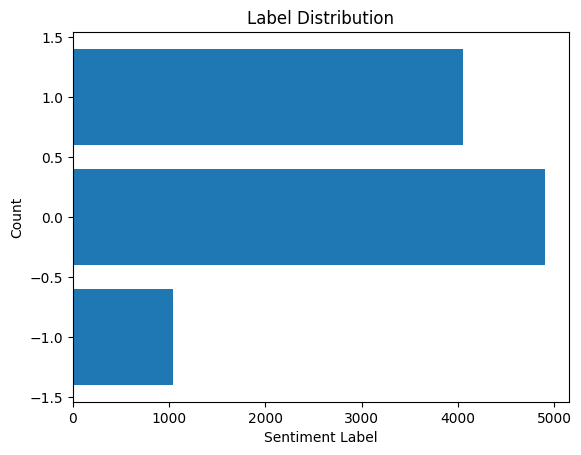

In [26]:
import matplotlib.pyplot as plt

label_counts = df_train['label'].value_counts()
plt.barh(label_counts.index, label_counts.values)
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

In [27]:
total_samples = len(df_train)

# Calculate class distribution as a percentage
label_0 = 5000
label_1 = 4000
label_minus1 = 1000

label_0_percentage = (label_0 / total_samples) * 100
label_1_percentage = (label_1 / total_samples) * 100
label_minus1_percentage = (label_minus1 / total_samples) * 100

print("Label 0 percentage:", label_0_percentage)
print("Label 1 percentage:", label_1_percentage)
print("Label -1 percentage:", label_minus1_percentage)

Label 0 percentage: 49.99500049995
Label 1 percentage: 39.99600039996
Label -1 percentage: 9.99900009999


A dataset is typically considered balanced when the class distribution is roughly equal, meaning that all classes have a similar number of samples. In this case, it's not perfectly balanced, but it's relatively close, and the class distribution isn't heavily skewed towards one class. In short, while it's not perfectly balanced (where each class would have exactly 33.33% in a three-class problem), the class distribution is not heavily skewed towards one class. The majority of the samples are in either Label 0 or Label 1, with Label -1 being the smallest class.

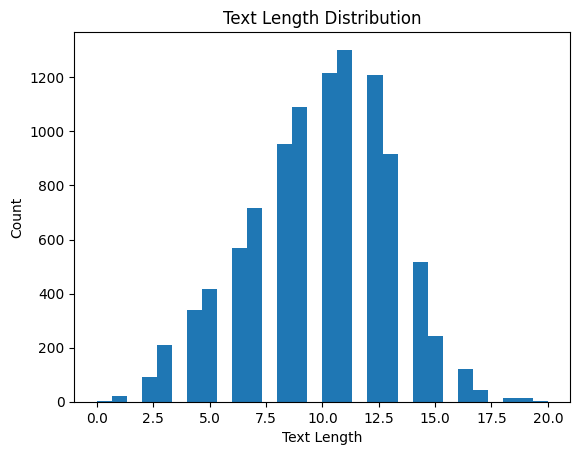

In [28]:
text_lengths = df_train['lemmatized'].apply(len)
plt.hist(text_lengths, bins=30)
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.title('Text Length Distribution')
plt.show()

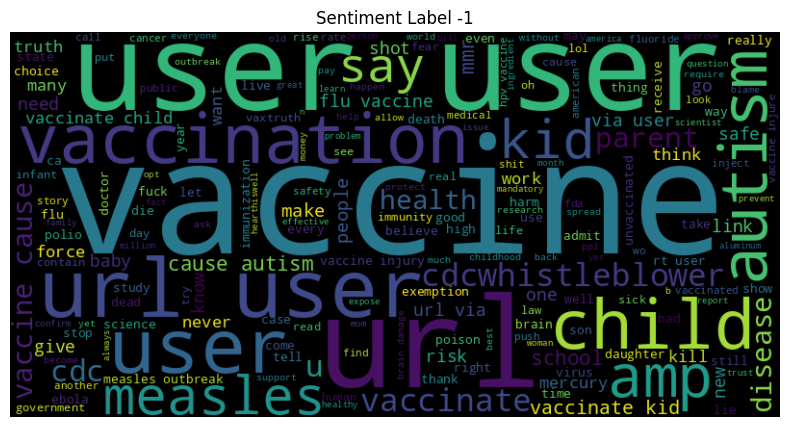

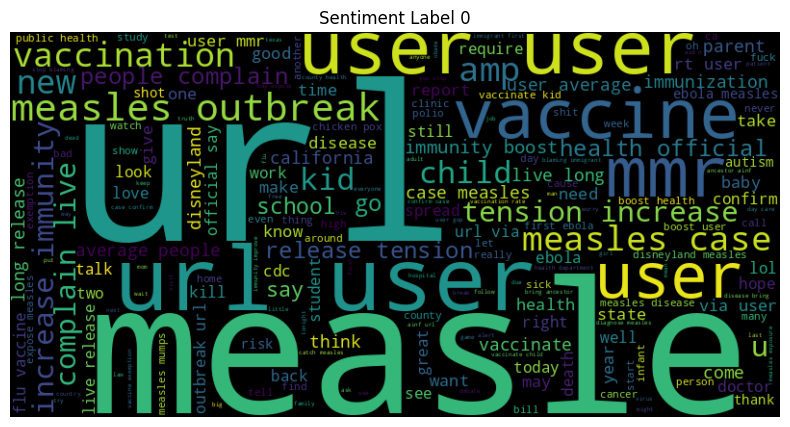

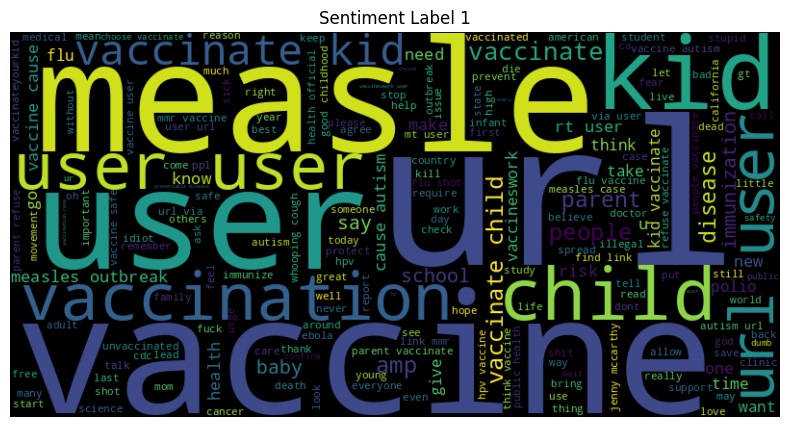

In [29]:
valid_sentiment_labels = [-1, 0, 1]
for label in valid_sentiment_labels:
    # Join the lists of lemmatized words within each row and store them in a new column
    df_train['lemmatized_text'] = df_train[df_train['label'] == label]['lemmatized'].apply(lambda x: ' '.join(x))

    text = " ".join(df_train[df_train['label'] == label]['lemmatized_text'])
    wordcloud = WordCloud(width=800, height=400).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f'Sentiment Label {label}')
    plt.axis("off")
    plt.show()


A word cloud is a visual appealing representation of words, where the size of the word is proportional to its frequency. Word clouds are often used to visualize text data, such as social media posts as seen in this dataset etc. They can be used to identify the most common words in a text, as well as the relationships between different words.

And from these three wordcloud to represent data uder the various labels, we see that some of the most common words are vaccine, url, measles and user. We would run some test to confirm if this true before we take any action.

In [30]:
from collections import Counter

# Initialize a Counter to count word occurrences
word_counts = Counter()

# Iterate through the "lemmatized" column row by row
for row in df_train['lemmatized']:
    # Iterate through the list of tokens in each row
    for token in row:
        # Update the word count
        word_counts[token] += 1


# Find the top 10 words with the highest counts
top_10_words = word_counts.most_common(10)

print("--------------------------------")
print("Top ten words in train dataset")
print("--------------------------------")

# Print the top 10 words and their counts
for word, count in top_10_words:
    print(f"{word}: {count}")


--------------------------------
Top ten words in train dataset
--------------------------------
user: 5595
url: 4634
measles: 3368
vaccine: 2665
vaccinate: 1629
get: 1421
kid: 1339
child: 1284
health: 998
mmr: 944


In [31]:
from collections import Counter

# Initialize a Counter to count word occurrences
word_counts = Counter()

# Iterate through the "lemmatized" column row by row
for row in df_test['lemmatized']:
    # Iterate through the list of tokens in each row
    for token in row:
        # Update the word count
        word_counts[token] += 1


# Find the top 10 words with the highest counts
top_10_words = word_counts.most_common(10)

print("--------------------------------")
print("Top ten words in test dataset")
print("--------------------------------")

# Print the top 10 words and their counts
for word, count in top_10_words:
    print(f"{word}: {count}")

--------------------------------
Top ten words in test dataset
--------------------------------
user: 3089
url: 2330
measles: 1714
vaccine: 1376
vaccinate: 867
get: 757
kid: 741
child: 662
health: 526
mmr: 471


In [32]:
# Words to remove
words_to_remove = ['user', 'url']

# Create a new "lemmatized" column with words removed
df_train['lemmatized'] = df_train['lemmatized'].apply(lambda row: [token for token in row if token not in words_to_remove])

# Print the modified "lemmatized" column
df_train


,safe_text,label,agreement,tokens,alpha,stop,lemmatized,lemmatized_text
0,me &amp; the big homie meanboy3000 #meanboy #m...,0.0,1.000000,"[me, &, amp, ;, the, big, homie, meanboy3000, ...","[me, amp, the, big, homie, meanboy, mb, mbs, m...","[amp, big, homie, meanboy, mb, mbs, mmr, stegm...","[amp, big, homie, meanboy, mb, mb, mmr, stegma...",NaN
1,i'm 100% thinking of devoting my career to pro...,1.0,1.000000,"[i, 'm, 100, %, thinking, of, devoting, my, ca...","[i, thinking, of, devoting, my, career, to, pr...","[thinking, devoting, career, proving, autism, ...","[think, devote, career, prove, autism, cause, ...",think devote career prove autism cause vaccine...
2,"#whatcausesautism vaccines, do not vaccinate y...",-1.0,1.000000,"[#, whatcausesautism, vaccines, ,, do, not, va...","[whatcausesautism, vaccines, do, not, vaccinat...","[whatcausesautism, vaccines, vaccinate, child]","[whatcausesautism, vaccine, vaccinate, child]",NaN
3,i mean if they immunize my kid with something ...,-1.0,1.000000,"[i, mean, if, they, immunize, my, kid, with, s...","[i, mean, if, they, immunize, my, kid, with, s...","[mean, immunize, kid, something, wo, secretly,...","[mean, immunize, kid, something, wo, secretly,...",NaN
4,thanks to <user> catch me performing at la nui...,0.0,1.000000,"[thanks, to, <, user, >, catch, me, performing...","[thanks, to, user, catch, me, performing, at, ...","[thanks, user, catch, performing, la, nuit, ny...","[thanks, catch, perform, la, nuit, nyc, show, ...",NaN
...,...,...,...,...,...,...,...,...
9996,living in a time where the sperm i used to was...,1.0,1.000000,"[living, in, a, time, where, the, sperm, i, us...","[living, in, a, time, where, the, sperm, i, us...","[living, time, sperm, used, waste, jenny, mcca...","[living, time, sperm, use, waste, jenny, mccar...",living time sperm use waste jenny mccarthy wel...
9997,<user> <user> in spite of all measles outbrea...,1.0,0.666667,"[<, user, >, <, user, >, in, spite, of, all, m...","[user, user, in, spite, of, all, measles, outb...","[user, user, spite, measles, outbreaks, judge,...","[spite, measles, outbreaks, judge, mi, threate...",user user spite measles outbreaks judge mi thr...
9998,interesting trends in child immunization in ok...,0.0,1.000000,"[interesting, trends, in, child, immunization,...","[interesting, trends, in, child, immunization,...","[interesting, trends, child, immunization, okl...","[interest, trend, child, immunization, oklahom...",NaN
9999,cdc says measles are at highest levels in deca...,0.0,1.000000,"[cdc, says, measles, are, at, highest, levels,...","[cdc, says, measles, are, at, highest, levels,...","[cdc, says, measles, highest, levels, decades,...","[cdc, say, measles, high, level, decade, return]",NaN


In [33]:
# Words to remove
words_to_remove = ['user', 'url']

# Create a new "lemmatized" column with words removed
df_test['lemmatized'] = df_test['lemmatized'].apply(lambda row: [token for token in row if token not in words_to_remove])

# Print the modified "lemmatized" column
df_test

,safe_text,tokens,alpha,stop,lemmatized
0,<user> <user> ... &amp; 4 a vaccine given 2 he...,"[<, user, >, <, user, >, ..., &, amp, ;, 4, a,...","[user, user, amp, a, vaccine, given, healthy, ...","[user, user, amp, vaccine, given, healthy, pee...","[amp, vaccine, give, healthy, peep, fda, think..."
1,students starting school without whooping coug...,"[students, starting, school, without, whooping...","[students, starting, school, without, whooping...","[students, starting, school, without, whooping...","[student, start, school, without, whoop, cough..."
2,"i'm kinda over every ep of <user> being ""rippe...","[i, 'm, kinda, over, every, ep, of, <, user, >...","[i, kinda, over, every, ep, of, user, being, r...","[kinda, every, ep, user, ripped, measles, let,...","[kinda, every, ep, rip, measles, let, get, bac..."
3,how many innocent children die for lack of vac...,"[how, many, innocent, children, die, for, lack...","[how, many, innocent, children, die, for, lack...","[many, innocent, children, die, lack, vaccinat...","[many, innocent, child, die, lack, vaccination..."
4,"cdc eyeing bird flu vaccine for humans, though...","[cdc, eyeing, bird, flu, vaccine, for, humans,...","[cdc, eyeing, bird, flu, vaccine, for, humans,...","[cdc, eyeing, bird, flu, vaccine, humans, thou...","[cdc, eye, bird, flu, vaccine, human, though, ..."
...,...,...,...,...,...
5172,jenny mccarthy is on new years rockin eve. wha...,"[jenny, mccarthy, is, on, new, years, rockin, ...","[jenny, mccarthy, is, on, new, years, rockin, ...","[jenny, mccarthy, new, years, rockin, done, la...","[jenny, mccarthy, new, year, rockin, do, latel..."
5173,measles reported in clark co. for 1st time sin...,"[measles, reported, in, clark, co., for, 1st, ...","[measles, reported, in, clark, for, time, sinc...","[measles, reported, clark, time, since, url]","[measles, report, clark, time, since]"
5174,<user> issues alert regarding measles in tx. k...,"[<, user, >, issues, alert, regarding, measles...","[user, issues, alert, regarding, measles, in, ...","[user, issues, alert, regarding, measles, keep...","[issue, alert, regard, measles, keep, ddx, dat..."
5175,i can't believe people don't vaccinate their k...,"[i, ca, n't, believe, people, do, n't, vaccina...","[i, ca, believe, people, do, vaccinate, their,...","[ca, believe, people, vaccinate, kids, vaccina...","[ca, believe, people, vaccinate, kid, vaccinat..."


In [34]:
df_train['text'] = df_train['lemmatized']

# Join the tokens in the "text" column into a sentence-like string
df_train['text'] = df_train['text'].apply(lambda tokens: ' '.join(tokens))

train_data = df_train[['text', 'label', 'agreement','lemmatized']]

train_data

,text,label,agreement,lemmatized
0,amp big homie meanboy mb mb mmr stegmanlife st...,0.0,1.000000,"[amp, big, homie, meanboy, mb, mb, mmr, stegma..."
1,think devote career prove autism cause vaccine...,1.0,1.000000,"[think, devote, career, prove, autism, cause, ..."
2,whatcausesautism vaccine vaccinate child,-1.0,1.000000,"[whatcausesautism, vaccine, vaccinate, child]"
3,mean immunize kid something wo secretly kill y...,-1.0,1.000000,"[mean, immunize, kid, something, wo, secretly,..."
4,thanks catch perform la nuit nyc show start je...,0.0,1.000000,"[thanks, catch, perform, la, nuit, nyc, show, ..."
...,...,...,...,...
9996,living time sperm use waste jenny mccarthy wel...,1.0,1.000000,"[living, time, sperm, use, waste, jenny, mccar..."
9997,spite measles outbreaks judge mi threaten put ...,1.0,0.666667,"[spite, measles, outbreaks, judge, mi, threate..."
9998,interest trend child immunization oklahoma cov...,0.0,1.000000,"[interest, trend, child, immunization, oklahom..."
9999,cdc say measles high level decade return,0.0,1.000000,"[cdc, say, measles, high, level, decade, return]"


In [35]:
df_test['text'] = df_test['lemmatized']

# Join the tokens in the "text" column into a sentence-like string
df_test['text'] = df_test['text'].apply(lambda tokens: ' '.join(tokens))

test_data = df_test[['text','lemmatized']]

test_data

,text,lemmatized
0,amp vaccine give healthy peep fda think worth ...,"[amp, vaccine, give, healthy, peep, fda, think..."
1,student start school without whoop cough vacci...,"[student, start, school, without, whoop, cough..."
2,kinda every ep rip measles let get back svu,"[kinda, every, ep, rip, measles, let, get, bac..."
3,many innocent child die lack vaccination year ...,"[many, innocent, child, die, lack, vaccination..."
4,cdc eye bird flu vaccine human though risk low...,"[cdc, eye, bird, flu, vaccine, human, though, ..."
...,...,...
5172,jenny mccarthy new year rockin do lately besid...,"[jenny, mccarthy, new, year, rockin, do, latel..."
5173,measles report clark time since,"[measles, report, clark, time, since]"
5174,issue alert regard measles keep ddx date peopl...,"[issue, alert, regard, measles, keep, ddx, dat..."
5175,ca believe people vaccinate kid vaccinate ever...,"[ca, believe, people, vaccinate, kid, vaccinat..."


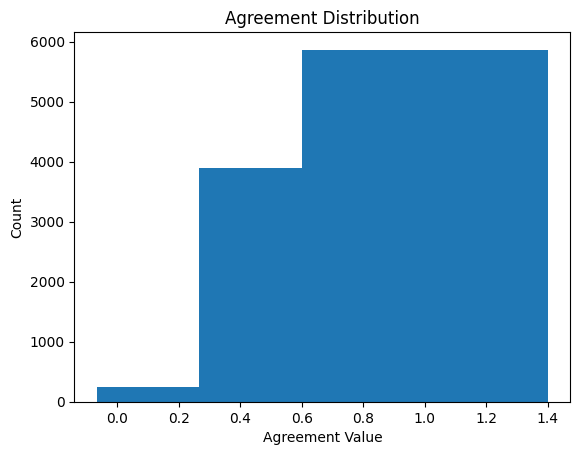

In [36]:
agreement_counts = df_train['agreement'].value_counts()
plt.bar(agreement_counts.index, agreement_counts.values)
plt.xlabel('Agreement Value')
plt.ylabel('Count')
plt.title('Agreement Distribution')
plt.show()

In [37]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5176 entries, 0 to 5176
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   safe_text   5176 non-null   object
 1   tokens      5176 non-null   object
 2   alpha       5176 non-null   object
 3   stop        5176 non-null   object
 4   lemmatized  5176 non-null   object
 5   text        5176 non-null   object
dtypes: object(6)
memory usage: 283.1+ KB


In [38]:
#Save splitted subsets
train_data.to_csv("/content/drive/MyDrive/p5/p5 dataset/train_data.csv", index=False)

In [39]:
#Save splitted subsets
test_data.to_csv("/content/drive/MyDrive/p5/p5 dataset/test_data.csv", index=False)